In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import utils
from data_statistical_features import Segment, SegmentStatistical

import os

# Load Data

In [3]:
df = pd.read_csv(utils.get_own_features_csv_path(segment_length=10, overlap_amount=0.9, hr_threshold=10, data_folder='data_patients'), index_col=False)

In [19]:
mask_inf = df['informative']
mask_non_inf = ~df['informative']
arr = df['peak_frequency_acf'].copy()
#print(df.loc[mask_inf, 'peak_frequency_acf'].describe())
# print(df.loc[mask_non_inf, 'peak_frequency_acf'].describe())
# arr = (arr * 60)
arr.describe()

count    830808.000000
mean          5.025612
std          18.398822
min           0.000000
25%           1.953125
50%           5.468750
75%           6.250000
max         667.000000
Name: peak_frequency_acf, dtype: float64

In [28]:
df = pd.read_csv(utils.get_own_features_csv_path(segment_length=10, overlap_amount=0.9, hr_threshold=10, data_folder='data_patients'), index_col=False)

features = df.drop(Segment.get_feature_name_array(), axis='columns')
features['brueser_sqi'] = df['brueser_sqi']
features = features.fillna(0)
informative_inf = df[Segment.get_feature_name_array()]
target = df['informative']
patient_id = df['patient_id']
features_new = df.drop(SegmentStatistical.get_feature_name_array(), axis='columns')
features_new['brueser_sqi'] = df['brueser_sqi']
df_new = features_new.copy()
df_new['error'] = df['error']

# Correlation Heatmap

In [ ]:
sns.heatmap(df_new.corr(), square=True, cmap ="RdYlGn")

In [ ]:
sns.heatmap(features_new.corr(), square=True, cmap ="RdYlGn")

# Paarweise geplottet

In [ ]:
cols = ['hf_ratio_acf', 'peak_frequency_acf', 'brueser_coverage', 'abs_energy', 'informative']
sns.pairplot(df[cols], kind='scatter', hue='informative', dropna=True)


In [ ]:
cols = ['interval_lengths_std', 'interval_lengths_range', 'interval_lengths_mean', 'error', 'informative']
sns.pairplot(df[cols], kind='scatter', hue='informative', dropna=True)


In [ ]:
cols = ['sqi_std', 'sqi_min', 'sqi_max', 'brueser_sqi', 'error', 'informative']
sns.pairplot(df[cols], kind='scatter', hue='informative', dropna=True)

In [ ]:
cols = ['peak_max','peak_min', 'peak_mean', 'error', 'informative']
sns.pairplot(df[cols], kind='scatter', hue='informative', dropna=True)

# Boxplots features

# Einfluss der Merkmale bei Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor


from ml_statistical_features import get_patient_split

In [51]:
forest = RandomForestClassifier(random_state=1)
features = features.replace([np.inf, -np.inf], 0)


x_train, x_test, y_train, y_test, groups_train, groups_test = get_patient_split(features, target, patient_id, test_size=0.2)

In [ ]:
forest.fit(x_train.fillna(0), y_train)

In [12]:
print("Trainings-Set: ", str(forest.score(x_train, y_train)))
print("Test-Set: ", str(forest.score(x_test, y_test)))

Trainings-Set:  0.9999985376867374
Trainings-Set:  0.9999985376867374
Test-Set:  0.6291303756124116
Test-Set:  0.6291303756124116


 1) hf_ratio_acf                   0.089325
 2) brueser_sqi                    0.083462
 3) interval_lengths_mean          0.073282
 4) interval_lengths_std           0.055002
 5) peak_frequency_acf             0.049645
 6) number_zero_crossings          0.044338
 7) sqi_max                        0.040159
 8) sqi_std                        0.040081
 9) interval_lengths_range         0.038789
10) sqi_min                        0.033025
11) mad                            0.031588
12) iqr                            0.031440
13) peak_mean                      0.030913
14) skewness                       0.028671
15) kurtosis                       0.026618
16) mean_signal_envelope           0.025124
17) variance_local_maxima          0.024679
18) template_corr_std              0.024427
19) abs_energy                     0.023466
20) minimum                        0.022607
21) variance_local_minima          0.022281
22) peak_std                       0.021972
23) range                       

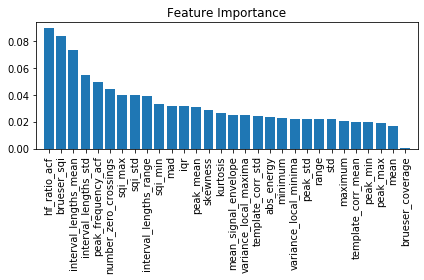

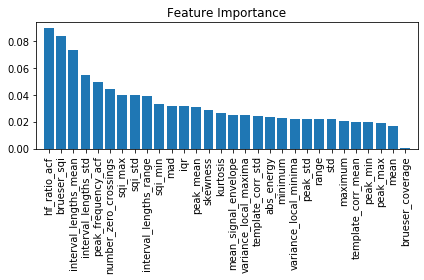

In [13]:
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(x_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, features.columns[indices[f]], importances[indices[f]]))
plt.title('Feature Importance')
plt.bar(range(x_train.shape[1]), importances[indices], align='center')
plt.xticks(range(x_train.shape[1]), features.columns[indices], rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.tight_layout()
plt.show()

In [ ]:
forest_regr = RandomForestRegressor(random_state=1)

y_train_regr = informative_inf.loc[y_train.index]['error']
print(x_train.columns)
# y_train_regr[y_train_regr > 10000] = 667
forest_regr.fit(x_train.dropna(axis='index'), y_train_regr)
print("Trainings-Set: ", str(forest_regr.score(x_train, df.loc[y_train.index]['error'])))
print("Test-Set: ", str(forest_regr.score(x_test, df.loc[y_test.index]['error'])))

Index(['minimum', 'maximum', 'mean', 'std', 'range', 'iqr', 'mad',
       'number_zero_crossings', 'kurtosis', 'skewness',
       'variance_local_maxima', 'variance_local_minima',
       'mean_signal_envelope', 'hf_ratio_acf', 'peak_frequency_acf',
       'abs_energy', 'interval_lengths_std', 'interval_lengths_range',
       'interval_lengths_mean', 'sqi_std', 'sqi_min', 'sqi_max', 'peak_max',
       'peak_min', 'peak_mean', 'peak_std', 'template_corr_mean',
       'template_corr_std', 'brueser_sqi'],
      dtype='object')


In [ ]:
y_pred = forest_regr.predict(x_test)
y_true = df.loc[y_test.index]['error']

print(np.max(y_pred))

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, mean_squared_error, mean_absolute_error

print("MSE: " + str(mean_squared_error(y_true, y_pred)))
print("MAE: " + str(mean_absolute_error(y_true, y_pred)))

y_pred_label = [err < 10 for err in y_pred]
y_true_label = [err < 10 for err in y_true]

class_names = ['non-informative', 'informative']
ConfusionMatrixDisplay(confusion_matrix(y_true_label, y_pred_label), display_labels=class_names).plot()
print(classification_report(y_true_label, y_pred_label, target_names=class_names))

In [ ]:
importances = forest_regr.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(x_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, features.columns[indices[f]], importances[indices[f]]))
plt.title('Feature Importance')
plt.bar(range(x_train.shape[1]), importances[indices], align='center')
plt.xticks(range(x_train.shape[1]), features.columns[indices], rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.tight_layout()
plt.show()

In [14]:
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler

In [15]:
std_scaler = StandardScaler()

x_std = std_scaler.fit_transform(x_test)

In [ ]:
pca = KernelPCA(n_components=2)
x_transform = pca.fit_transform(x_std)
df = pd.DataFrame(x_transform)
df['informative'] = y_test.values

sns.pairplot(df, kind='scatter', hue='informative')

In [ ]:
pca = KernelPCA(n_components=2, kernel='cosine')
x_transform = pca.fit_transform(x_std)
df = pd.DataFrame(x_transform)
df['informative'] = y_test.values

sns.pairplot(df, kind='scatter', hue='informative')

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis(n_components=1)
clf.fit(x_std, y_test)
x_lda = clf.transform(x_std)
df_lda = pd.DataFrame(x_lda)
df_lda['informative'] = y_test.values

sns.pairplot(df_lda, kind='scatter', hue='informative')

In [ ]:
pca = KernelPCA(n_components=2, kernel='rbf')
x_transform = pca.fit_transform(x_std)

df = pd.DataFrame(x_transform)
df['informative'] = y_test.values

sns.pairplot(df, kind='scatter', hue='informative')

In [ ]:
from sklearn.neighbors import NeighborhoodComponentsAnalysis

nca = NeighborhoodComponentsAnalysis(n_components=2)
x_nca = nca.fit_transform(x_std, y_test)

df_nca = pd.DataFrame(x_lda)
df_nca['informative'] = y_test.values

sns.pairplot(df_nca, kind='scatter', hue='informative')